In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
titanic = pd.read_csv('../data/titanic.csv')
print(titanic.shape)
titanic.head()

(887, 8)


,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


The `Titanic` data set collects information about almost 900 passangers aboard the Titanic during the fateful voyage when it crashed into an iceberg in 1912 and sank. The information includes their age; the fare they paid for their ticket (in British pounds); their sex; and the passenger class `Pclass`, with 1st class corresponding to VIP treatment and 3rd class corresponding to a much less luxurious experience. Crucially, the data set also records whether that passenger survived the sinking of the ship, with `1` indicating that the passenger survived and `0` indicating that the passenger tragically perished.

We are eventually going to train an algorithm to predict whether a passenger survived the Titanic based on their available information. Before we do, let's get a sense for some trends using familiar pandas summarization.

# Exploratory analysis

How wealthy were these passengers? We can't know for certain, but we can get a sense for how much was paid for each passenger class.

In [3]:
titanic.groupby('Pclass').mean(numeric_only=True)

# group everyone by passenger class, and calculate mean 

,Survived,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
Pclass,,,,,
1,0.629630,38.788981,0.416667,0.356481,84.154687
2,0.472826,29.868641,0.402174,0.380435,20.662183
3,0.244353,25.188747,0.620123,0.396304,13.707707


- The average price of 84 pounds for a first-class ticket corresponds to nearly \$15,000 USD today.
- The second-class ticket corresponds to roughly \$3,500.
- The third class ticket corresponds to roughly \$2,500.

We can safely assume that the first-class passengers were indeed substantially more wealthy on average than the others.

Did Pclass have an effect on survival rate?

This difference in wealth made a considerable difference in how likely passengers were to survive.

In [4]:
# 'save the women first' (and maybe children, TBD)

titanic.groupby(['Pclass', 'Sex']).mean(numeric_only=True)

Survived        Age  Siblings/Spouses Aboard  \
Pclass Sex                                                    
1      female  0.968085  35.255319                 0.553191   
       male    0.368852  41.511639                 0.311475   
2      female  0.921053  28.980263                 0.486842   
       male    0.157407  30.493796                 0.342593   
3      female  0.500000  22.135417                 0.895833   
       male    0.137026  26.470612                 0.504373   

               Parents/Children Aboard        Fare  
Pclass Sex                                          
1      female                 0.457447  106.125798  
       male                   0.278689   67.226127  
2      female                 0.605263   21.970121  
       male                   0.222222   19.741782  
3      female                 0.798611   16.118810  
       male                   0.227405   12.695466

This table reflects the famous maritime tradition of prioritizing women and children first into the lifeboats, resulting in vastly higher survival rates among women in these data. Note the role of class: a 1st-class woman was twice as likely to survive as a third class woman, and a 1st-class man was nearly three times as likely to survive as a 3rd class man.

In [5]:
# Characteristics of who survived and who didn't

titanic.groupby('Survived').mean(numeric_only=True)

,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
Survived,,,,,
0,2.528440,30.138532,0.557798,0.332110,22.208584
1,1.950292,28.408392,0.473684,0.464912,48.395408


In [6]:
titanic.groupby('Survived').Sex.value_counts()

Survived  Sex   
0         male      464
          female     81
1         female    233
          male      109
Name: count, dtype: int64

# Our first ML algorithm (classification)

We'd like to develop automated models that can use these trends and others to make predictions about survival. However, we need to do a bit of data cleaning before we're ready for this. In particular, machine learning algorithms don't really get text, so we need to transform text data into numbers before we can proceed. Here's how we can encode the `Sex` data. 


We also don't really have any use for the actual names of passengers, so let's just remove that column.

In [7]:
titanic = titanic.drop(['Name'], axis=1) # drop the column that is named 'Name'
titanic.head()

,Survived,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


In [8]:
# Turn Sex column into numbers
is_F = (titanic['Sex'] == 'female') # array of True and False
titanic['Sex'] = is_F.astype(int) # 1 = female, 0 = male
titanic.head()

,Survived,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,0,22.0,1,0,7.2500
1,1,1,1,38.0,1,0,71.2833
2,1,3,1,26.0,0,0,7.9250
3,1,1,1,35.0,1,0,53.1000
4,0,3,0,35.0,0,0,8.0500


The next thing to do is to separate out the target data Survived from the predictor data (everything else).

In [9]:
y = pd.DataFrame(titanic['Survived'])
y

,Survived
0,0
1,1
2,1
3,1
4,0
...,...
882,0
883,1
884,0
885,1


In [10]:
X = titanic.drop(columns=['Survived']) # drop 'survived' column
X

,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,3,0,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,3,1,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,3,0,35.0,0,0,8.0500
...,...,...,...,...,...,...
882,2,0,27.0,0,0,13.0000
883,1,1,19.0,0,0,30.0000
884,3,1,7.0,1,2,23.4500
885,1,0,26.0,0,0,30.0000


To use a machine learning model from `scikit-learn`, you should import the relevant model. For example, let's use a decision tree classifier.

Arguments passed to the model upon instantiation (`max_depth`=2) are typically used to control how complex the model can be. These arguments are often referred to as hyperparameters. In practice, we don't usually know what the right hyperparameters are, and so we need to resort to various computational techniques (in coming lectures) to select good ones.

In [11]:
from sklearn import tree 
# sklearn is a package called scikit-learn 
# that contains a lot of useful ML algorithms

T = tree.DecisionTreeClassifier(max_depth=2) 
# More on this in lec 20

T.fit(X, y) # find the best f


DecisionTreeClassifier(max_depth=2)

X -> [model] -> f(X)

What does the score function calculate? It depends by model, but in the case of classifiers, the score is the fraction of the time that the model made the correct prediction. The score does the same job as the loss function, but the signs are flipped -- high scores mean good models.

In [12]:
T.score(X, y) 
# our classifier model T predicted correctly about 79% of 887 passengers 

0.7914317925591883

Our model was able to use the predictor variables to be right nearly 80% of the time. That's pretty impressive, but there is an important problem here. When doing machine learning, it's not advised to score or evaluate your model on the same data used for training or fitting the model. We'll come back to this in the next lecture.

In most cases, you should aim to understand how your model makes the decisions that it does. This is the problem of machine learning interpretation.

Every machine learning algorithm has both strengths and weaknesses when it comes to interpretation. Decision trees are pretty pleasant to interpret, as they correspond to "flow-chart" style reasoning that many of us are familiar with. The `tree` module of `scikit-learn` provides a convenient method for visualizing decision trees.

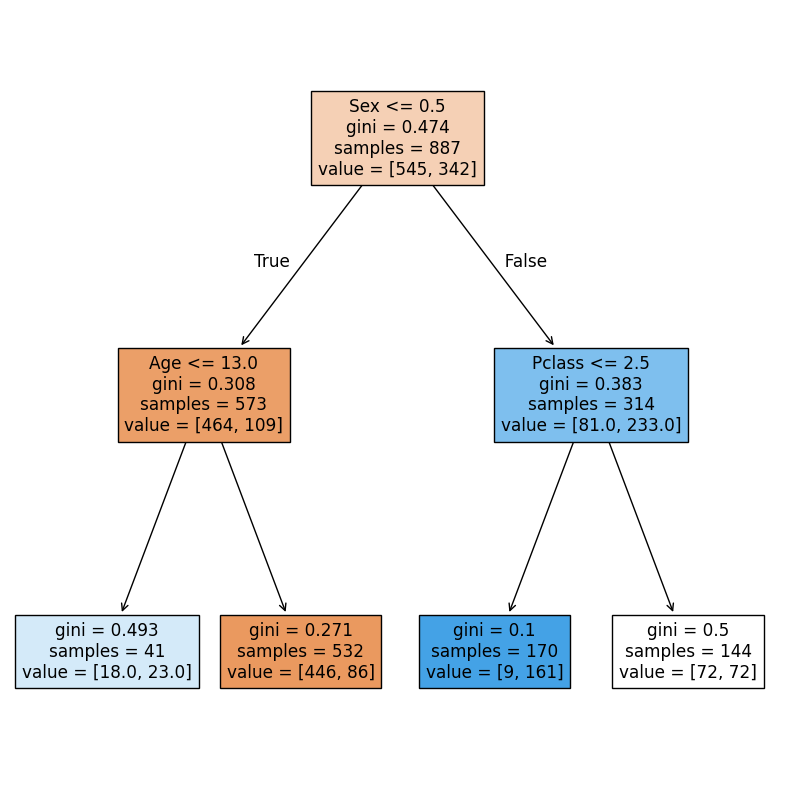

In [13]:
fig, ax = plt.subplots(1, figsize = (10, 10))
p = tree.plot_tree(T, 
                   filled=True, 
                   feature_names=X.columns)

The automated decision tree classifier has found the following rule to predict whether a passenger survived the Ttianic. First, check whether Sex <= 0.5 -- that is, check whether the passenger is male (0) or female (1).

- If the passenger is male, then check how old they are. If they are younger than or equal to 13 years old, the algorithm gives them a fair chance of survival (remember: "women and children."). Otherwise, the algorithm gives them very low odds indeed (86/532).

- If so, next check whether the passenger was first or second-class. If so, then they survive with high probability (161/170); otherwise the algorithm isn't sure and gives them a roughly 50-50 chance.

We've now gone through one cycle of:

1. Acquiring data.
2. Exploratory analysis.
3. Modeling.
4. Interpreting results.

In practice, we would not stop here. Having trained our model, we should then ask:

- What new insights can we gain from our model about the underlying data set?
- Can we improve our model?
- How can we use what we have learned in other data sets?

These questions, and many others, are part of the cycle of data science!

if we have time... regression example

In [14]:
# controls random number generation
# always get the same data
np.random.seed(1234) 

# true model is linear with a = 1 and b = 1
a = 1
b = 1

n_points = 100

X = np.random.rand(n_points)
Y = a*X + b + 0.2*np.random.randn(n_points) # final term is random noise

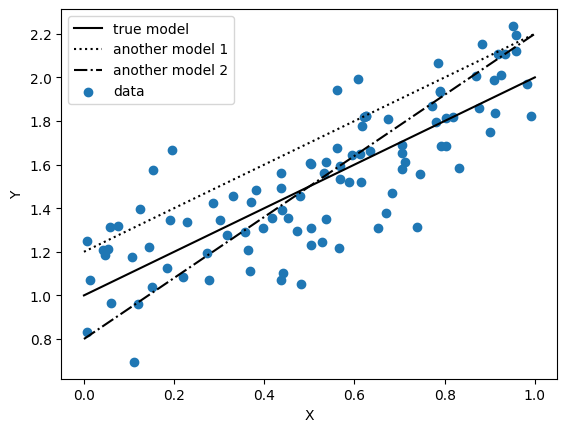

In [15]:
fig, ax = plt.subplots(1)

ax.plot([0,1], [1, 2], color = "black", label = "true model")
ax.plot([0,1], [1.2, 2.2], color = "black", linestyle=':', label = "another model 1")
ax.plot([0,1], [0.8, 2.2], color = "black", linestyle='-.', label = "another model 2")
ax.scatter(X, Y, label = "data")
ax.set(xlabel='X', ylabel='Y')
plt.legend()